### This section is ONLY about cleaning, selecting features & Model Training.

In [1]:
import pandas as pd

df = pd.read_csv('../data/winequality-all.csv')

df['free sulfur dioxide'].fillna(df['free sulfur dioxide'].median(), inplace=True)
df['total sulfur dioxide'].fillna(df['total sulfur dioxide'].median(), inplace=True)

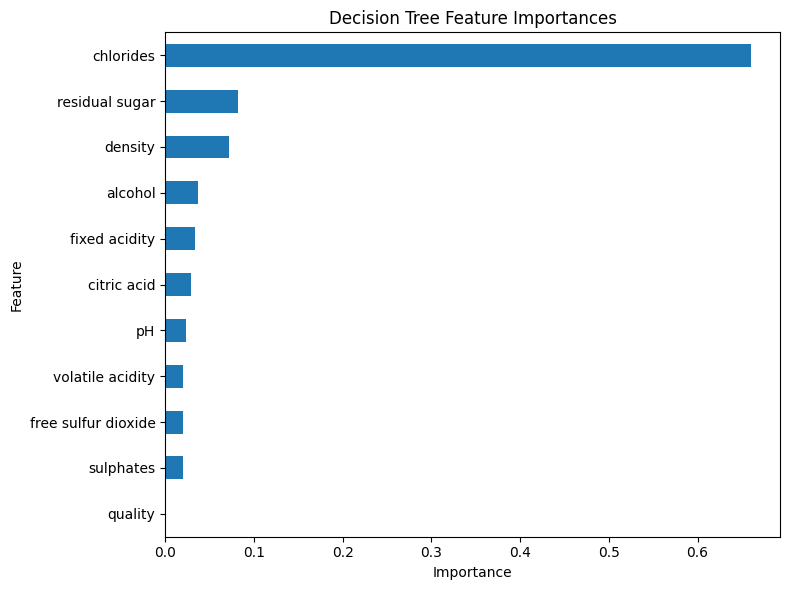

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Encoding target variable 
label_encoder = LabelEncoder()
df['type'] = label_encoder.fit_transform(df['type'])  

# Droping highly correlated feature
df_filtered = df.drop(columns=['total sulfur dioxide'])  

X = df_filtered.drop(columns=['type'])
y = df_filtered['type']

# Normalizing features 
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Decision Tree Classifier
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

# feature importances
feature_importances = pd.Series(tree.feature_importances_, index=X.columns)

plt.figure(figsize=(8, 6))
feature_importances.sort_values(ascending=True).plot(kind='barh')
plt.title("Decision Tree Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [3]:
# Selecting features with importance
selected_features = feature_importances[feature_importances > 0.03].index.tolist()
X_selected = X[selected_features]
df_clean = df[selected_features + ['type']]
print("Selected Features:", selected_features)

Selected Features: ['fixed acidity', 'residual sugar', 'chlorides', 'density', 'alcohol']


## Distribution of the target variable

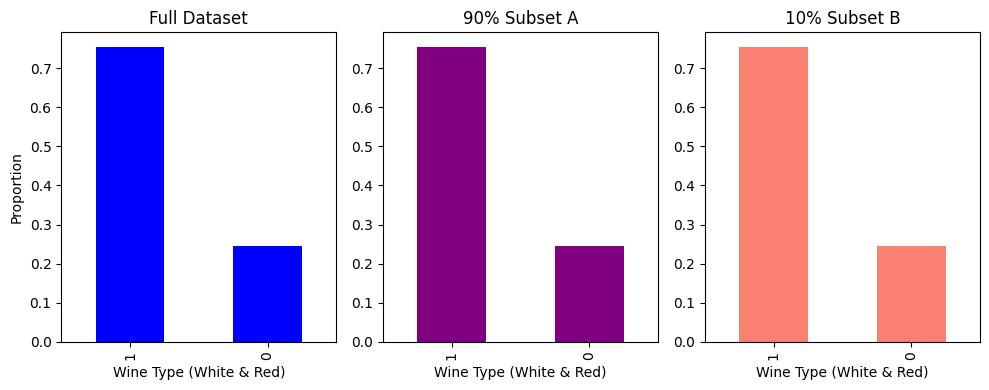

In [4]:
# Shuffling and splitting
X_A, X_B, y_A, y_B = train_test_split(
    X_selected, y, test_size=0.10, random_state=42, stratify=y
)

def plot_distribution(y_all, y_A, y_B):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    y_all.value_counts(normalize=True).plot(kind='bar', color='blue')
    plt.title("Full Dataset")
    plt.xlabel("Wine Type (White & Red)")
    plt.ylabel("Proportion")

    plt.subplot(1, 3, 2)
    y_A.value_counts(normalize=True).plot(kind='bar', color='purple')
    plt.title("90% Subset A")
    plt.xlabel("Wine Type (White & Red)")

    plt.subplot(1, 3, 3)
    y_B.value_counts(normalize=True).plot(kind='bar', color='salmon')
    plt.title("10% Subset B")
    plt.xlabel("Wine Type (White & Red)")

    plt.tight_layout()
    plt.show()

plot_distribution(y, y_A, y_B)

## Decision Tree model Training

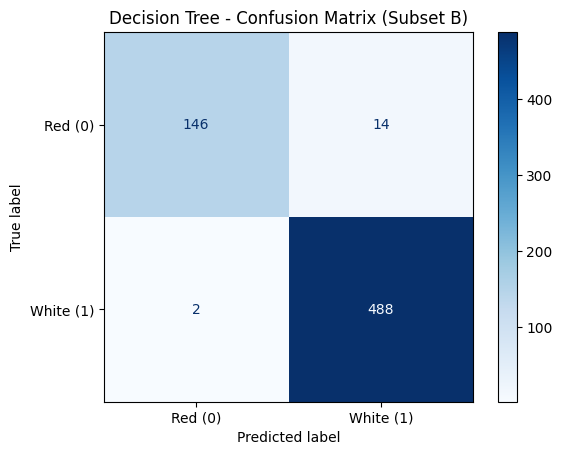

Confusion Matrix:
 [[146  14]
 [  2 488]]
Classification Report:

              precision    recall  f1-score   support

         Red       0.99      0.91      0.95       160
       White       0.97      1.00      0.98       490

    accuracy                           0.98       650
   macro avg       0.98      0.95      0.97       650
weighted avg       0.98      0.98      0.98       650

              precision    recall  f1-score   support

         Red       0.97      0.92      0.94      1439
       White       0.97      0.99      0.98      4408

    accuracy                           0.97      5847
   macro avg       0.97      0.95      0.96      5847
weighted avg       0.97      0.97      0.97      5847



In [5]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Training Decision Tree
dt_model = DecisionTreeClassifier(max_depth=5, min_samples_split=10, random_state=42)
dt_model.fit(X_A, y_A)

# Predicting
y_pred_dt = dt_model.predict(X_B)
xa_pred_dt = dt_model.predict(X_A)

# Confusion Matrix
cm = confusion_matrix(y_B, y_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Red (0)', 'White (1)'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Decision Tree - Confusion Matrix (Subset B)")
plt.show()
print("Confusion Matrix:\n", cm)

# Classification Report
print("Classification Report:\n")
print(classification_report(y_B, y_pred_dt, target_names=['Red', 'White']))
print(classification_report(y_A, xa_pred_dt, target_names=['Red', 'White']))


## Naïve Bayes model

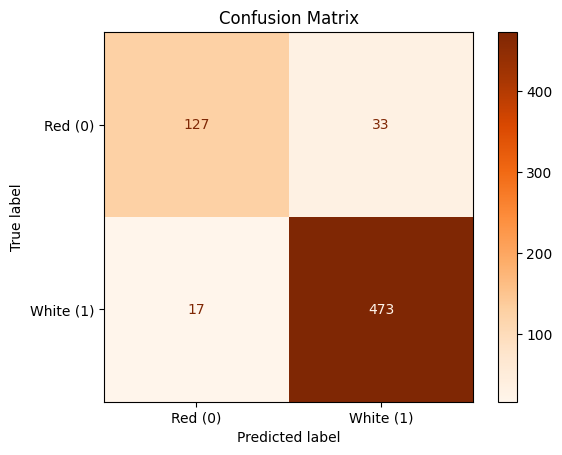

Confusion Matrix:
 [[127  33]
 [ 17 473]]
Classification Report:

              precision    recall  f1-score   support

         Red       0.88      0.79      0.84       160
       White       0.93      0.97      0.95       490

    accuracy                           0.92       650
   macro avg       0.91      0.88      0.89       650
weighted avg       0.92      0.92      0.92       650

              precision    recall  f1-score   support

         Red       0.87      0.77      0.82      1439
       White       0.93      0.96      0.95      4408

    accuracy                           0.92      5847
   macro avg       0.90      0.87      0.88      5847
weighted avg       0.91      0.92      0.91      5847



In [6]:
from sklearn.naive_bayes import GaussianNB

# Training Naïve Bayes 
nb_model = GaussianNB()
nb_model.fit(X_A, y_A)

# Predicting
y_pred_nb = nb_model.predict(X_B)
xa_pred_nb = nb_model.predict(X_A)

# Confusion Matrix
cm_nb = confusion_matrix(y_B, y_pred_nb)
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=['Red (0)', 'White (1)'])
disp_nb.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix")
plt.show()
print("Confusion Matrix:\n", cm_nb)

# Classification Report
print("Classification Report:\n")
print(classification_report(y_B, y_pred_nb, target_names=['Red', 'White']))
print(classification_report(y_A, xa_pred_nb, target_names=['Red', 'White']))


## 10-fold cross validation

In [7]:
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import cross_val_score
import numpy as np

X_cv = df_clean[selected_features]
y_cv = df_clean['type']

f1_scorer = make_scorer(f1_score, pos_label=1)

# Decision Tree 
dt_model = DecisionTreeClassifier(max_depth=5, min_samples_split=10, random_state=42)
dt_f1_scores = cross_val_score(dt_model, X_cv, y_cv, cv=10, scoring=f1_scorer)
print("Decision Tree - F1 scores:", dt_f1_scores)
print("Decision Tree - Average F1 score:", np.mean(dt_f1_scores))

# Naïve Bayes 
nb_model = GaussianNB()
nb_f1_scores = cross_val_score(nb_model, X_cv, y_cv, cv=10, scoring=f1_scorer)
print("Naïve Bayes - F1 scores:", nb_f1_scores)
print("Naïve Bayes - Average F1 score:", np.mean(nb_f1_scores))

Decision Tree - F1 scores: [0.98383838 0.98885512 0.97556008 0.97535934 0.96994819 0.9759519
 0.976      0.9760479  0.97995992 0.97017893]
Decision Tree - Average F1 score: 0.9771699765544042
Naïve Bayes - F1 scores: [0.95975855 0.97325103 0.93933054 0.95147679 0.95733611 0.95427435
 0.94891945 0.93450635 0.93933464 0.89700375]
Naïve Bayes - Average F1 score: 0.9455191566439861


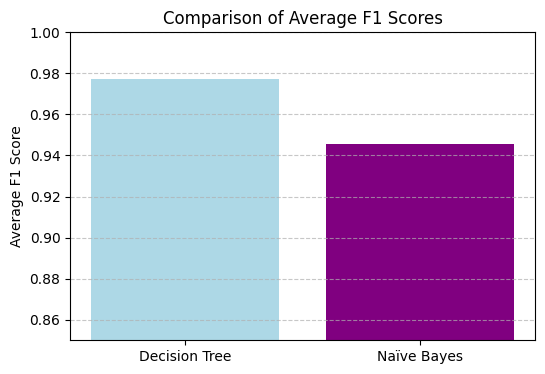

In [8]:
# Average F1-scores
dt_avg = np.mean(dt_f1_scores)
nb_avg = np.mean(nb_f1_scores)

plt.figure(figsize=(6, 4))
plt.bar(['Decision Tree', 'Naïve Bayes'], [dt_avg, nb_avg], color=['lightblue', 'purple'])
plt.ylabel('Average F1 Score')
plt.title('Comparison of Average F1 Scores')
plt.ylim(0.85, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()